In [46]:
# importing libraries
import csv
import sklearn.utils
import sklearn.model_selection
import copy
import math
import matplotlib.pyplot as plt
import pandas as pd
import random
import json
seed = 13

In [41]:
# Import CSV data into csv_data

def open_csv(filename): 
        
    with open(filename, 'r', newline='',  encoding='utf-8-sig') as file: 

        csv_reader = csv.reader(file)

        # iterates over rows, checks if row isn't empty, then adds it to csv_data
        csv_data = [row for row in csv_reader if row]
        # Alternative: csv_data = list(csv_data)

    # check to see if csv_data was imported
    # print(csv_data[0])

    return csv_data

In [23]:
##### HELPER FUNCTIONS #####
def get_attribute_of_index(_attr_list, _index): 
    return _attr_list[_index]
def get_index_of_attribute(_attr_list, _attr): 
    return _attr_list.index(_attr)

# returns entropy of set by i gain metric. 
def set_entropy_igain(class_count, partition_len):
    set_entropy = 0
    for num_in_class in class_count.values():
        # set entropy += FOR ALL LABELS: -instances/total_instances*log(instances/total_instances)
        # ignore adding if the num_in_class == 0
        if num_in_class != 0:
            set_entropy += -(num_in_class/partition_len)*math.log((num_in_class/partition_len), 2)
    return set_entropy

# returns entropy of set by gini metric
def set_entropy_gini(class_count, partition_len):
    set_entropy = 1
    for num_in_class in class_count.values():
        # subtract from 1,avoid dividing by zero
        if (partition_len > 0):
            set_entropy -=  math.pow((num_in_class/partition_len),2)
    return set_entropy
    
#returns: count of each class {a: num, b: num, c: num} in entries as a dictionary
def count_classes(_entries, _attr_list, _possible_classes, _label_attr_name): 

    class_count = {key: 0 for key in _possible_classes} # Now Accepts multiple values, 
    index_of_label = get_index_of_attribute(_attr_list, _label_attr_name)
    for entry in _entries: 
        # target is the last attribute 
        class_count[entry[index_of_label]] += 1
    return class_count

#returns the set of attributes in _dataset that match a vote value for an attribute
def get_data_matching_attribute_value(_dataset, _attr, _attr_list, _vote_value):
    # get the index of the attribute 
    decision_attr_index = get_index_of_attribute(_attr_list, _attr)

    matching_data = []
    # iterate through _dataset
    for datapoint in _dataset: 
        # if the value inside equal to _vote_value, add it to matching_data
        if datapoint[decision_attr_index] == _vote_value:
            matching_data.append(datapoint)
    # print("matching_data len: " + str(len(matching_data)))
    return matching_data

############################################
#returns the best attribute for splitting dataset based on _attr_decider_function, object
# {'decision_attr': "", 'numerical': False, 'numerical_splitter': -1}
###########################################
def get_best_attribute(_dataset, _attr_list, _remaining_attr, _attr_decider_function, _attr_dict, _possible_classes, _label_attr_name): 
    # default value

    best_attr = "default" # _remaining_attr[0]
        # default best avg_entropy
    # for every attribute, calculate the average entropy of eadch set
    best_splitters_per_attr = {}
    lowest_avg_entropy = -1

    for attr in _remaining_attr:
        avg_entropy = 0
        num_sets = -1

        # number of sets for taking the average
        ################ NUMERICAL ################
        if (_attr_dict[attr] == -1): 
            attr_idx = get_index_of_attribute(_attr_list,attr)

            # sorted set of all unique values of attr
            sorted_set_vals = sorted(list(set([datapoint[attr_idx] for datapoint in _dataset]))) # all values of the value. 

            # make splitting vals be mean of consecutive numbers
            splitters = []
            for i in range(0, len(sorted_set_vals)-1):
                splitters.append(.5*(sorted_set_vals[i]+sorted_set_vals[i+1]))

            # FIND BEST SPLITTER 

            best_splitter =  -1
            lowest_split_entropy = -1

            for current_splitter in splitters:
                avg_split_entropy = 0
                num_sets = 2 # number of sets for i_gain average.

                # make partitions. 
                partitionLeq = [val for val in _dataset if val[attr_idx] <= current_splitter]
                partitionGt = [val for val in _dataset if val[attr_idx] > current_splitter]

                for partition in [partitionLeq, partitionGt]:

                    if len(partition) == 0: 
                        num_sets -= 1
                    # get count of classes within partition
                    class_count = count_classes(partition, _attr_list, _possible_classes=_possible_classes, _label_attr_name =_label_attr_name)


                    if _attr_decider_function== "i_gain": 
                        avg_split_entropy += set_entropy_igain(class_count=class_count, partition_len=len(partition))
                    ###### GINI METRIC ######
                    elif _attr_decider_function== "gini": 
                        # WEIGHTED AVERAGE
                        avg_split_entropy += (len(partition)/len(_dataset))*set_entropy_gini(class_count=class_count, partition_len=len(partition))
                
                if (best_splitter == -1 or avg_split_entropy < lowest_split_entropy):
                    lowest_split_entropy = avg_split_entropy
                    best_splitter = current_splitter

            # At the end: choose best splitter to be avg_entropy
            best_splitters_per_attr[attr] = best_splitter
            avg_entropy = lowest_split_entropy

        else:
        ################ CATEGORICAL #################
            partition = []
            num_sets = len(_attr_dict[attr]) 

            # for every possibly vote value 0,1,2 partition, add set_entropy to avg_entropy
            for vote_value in _attr_dict[attr]: 
                partition = get_data_matching_attribute_value(_dataset=_dataset, _attr=attr, _attr_list=_attr_list, _vote_value=vote_value)
                
                # decrease number of sets if a partition is empty (i_gain)
                if len(partition) == 0: 
                    num_sets -= 1
                
                class_count = count_classes(partition, _attr_list, _possible_classes=_possible_classes, _label_attr_name =_label_attr_name)

                ###### INFO GAIN METRIC ######
                if _attr_decider_function== "i_gain": 
                    avg_entropy += set_entropy_igain(class_count=class_count, partition_len=len(partition))

                ###### GINI METRIC ######
                elif _attr_decider_function== "gini": 
                    # WEIGHTED AVERAGE
                    avg_entropy += (len(partition)/len(_dataset))*set_entropy_gini(class_count=class_count, partition_len=len(partition))
        
            # Non-Weighted Average
            if (_attr_decider_function == "i_gain"):
                avg_entropy = avg_entropy/num_sets 

        # if the entropy of this attribute is lowest, then change lowest
        if (lowest_avg_entropy == -1 or avg_entropy < lowest_avg_entropy):
        
            lowest_avg_entropy = avg_entropy
            best_attr = attr
    
    if _attr_dict[best_attr] == -1: # best attribute is numerical
        return {'decision_attr': best_attr, 'numerical': True, 'numerical_splitter': best_splitters_per_attr[best_attr], 'partition_entropy': lowest_avg_entropy}
    else: 
        return {'decision_attr': best_attr, 'numerical': False, 'numerical_splitter': -1, 'partition_entropy': lowest_avg_entropy}


######################################
    # DECISION TREE FUNCTION #
######################################


def decision_tree(_dataset, _attr_list, _remaining_attr, _attr_decider_function, _attr_dict, _label_attr_name, _minimal_size_for_split, _minimal_gain, _maximal_depth, _cur_depth): 
    
    _attr_list = copy.copy(_attr_list)
    _dataset =copy.copy(_dataset)

    #classes for label: 
    possible_classes = _attr_dict[_label_attr_name] 
    # create a new node
    node = {'is_leaf': False, 'leaf_label': 0, 'decision_attr': '', 'numerical': False, 'numerical_splitter': -1, 'children':{}}
    
    # get number of each class as class_count = {'0': 1231, '1': 121}
    class_count = count_classes(_dataset, _attr_list, _possible_classes=possible_classes, _label_attr_name=_label_attr_name)
    
    # STOPPING CRITERIA: 
    # if all instances in D belong to same class y, return that class
    for label_index in possible_classes:
        if class_count[label_index] == len(_dataset):
            node['leaf_label'] = label_index
            node['is_leaf'] = True
            return node
    
    # label the class with highest instances in class_count as majority class
    max_pair = list(class_count.items())[0]
    for item in list(class_count.items()):
        if item[1] > max_pair[1]:
            max_pair = item
    majority_class = max_pair[0]

    # STOPPING CRITERIA: 
    # if there are no more attributes to be tested, return highest class in D
    if len(_remaining_attr) == 0:
        node['leaf_label'] = majority_class
        node['is_leaf'] = True
        return node
    
    # ####_minimal_size_for_split:#### If Minimal Size for split is not -1, then stop when len remaining attributes is less than _minimal_size_for_split
    if _minimal_size_for_split > 0 and len(_dataset) < _minimal_size_for_split: 
        node['leaf_label'] = majority_class
        node['is_leaf'] = True
        return node
    
    # ####_cur_depth###
    if (_maximal_depth > 0 and _cur_depth >= _maximal_depth):
        node['leaf_label'] = majority_class
        node['is_leaf'] = True
        return node
    
    random_attributes = random.sample(_remaining_attr, int(math.sqrt(len(_remaining_attr))))
    
    # let A be the best attribute to split the dataset D
    best_attribute_object = get_best_attribute(_dataset, _attr_list, random_attributes, _attr_decider_function, _attr_dict, _possible_classes= possible_classes, _label_attr_name=_label_attr_name)

    ## MINIMAL GAIN ##
    if _minimal_gain > 0: 
        dataset_entropy = 0 
        if _attr_decider_function == "i_gain": 
            dataset_entropy = set_entropy_igain(class_count, len(_dataset))
        elif _attr_decider_function == "gini": 
            dataset_entropy = set_entropy_gini(class_count, len(_dataset))
        else: 
            print("unsupported attribute decider")
        if dataset_entropy - best_attribute_object['partition_entropy'] < _minimal_gain:
            node['leaf_label'] = majority_class
            node['is_leaf'] = True
            return node


    best_attr = best_attribute_object['decision_attr']
    numerical = best_attribute_object['numerical']
    best_attr_idx = get_index_of_attribute(_attr_list,best_attr) # index of best attribute 
    
    # N is by default a decision node

    # Delete best attribute fom the _remaining_attr = L

    # RANDOM FOREST: NO DELETING ATRRIBUTES: 
    # _remaining_attr = [attr for attr in _remaining_attr if attr != best_attr]

    node['decision_attr'] = best_attr #assign best attribute and numerical boolean
    node['numerical'] = numerical

    ####### NUMERICAL ######
    if numerical:
        numerical_splitter = float(best_attribute_object['numerical_splitter'])
        node['numerical_splitter'] = numerical_splitter
        node['children'] = {"leq": -1, "gt": -1}
        
        # partition into partitionLeq
        partitionLeq = [val for val in _dataset if val[best_attr_idx] <= numerical_splitter]
        partitionGt = [val for val in _dataset if val[best_attr_idx] > numerical_splitter]
        
        # create edges from node
        if len(partitionLeq) == 0: 
            node['children']["leq"] = {'is_leaf': True, 'leaf_label': majority_class, 'decision_attr': '',  'numerical': False, 'numerical_splitter': -1, 'children':{}}
        else: 
            node['children']["leq"] = decision_tree(partitionLeq, _attr_list, _remaining_attr, _attr_decider_function, _attr_dict, _label_attr_name, _minimal_size_for_split, _minimal_gain, _maximal_depth, _cur_depth+1)
        if len(partitionGt) == 0: 
            node['children']["gt"] = {'is_leaf': True, 'leaf_label': majority_class, 'decision_attr': '',  'numerical': False, 'numerical_splitter': -1, 'children':{}}
        else: 
            node['children']["gt"] = decision_tree(partitionGt, _attr_list, _remaining_attr, _attr_decider_function, _attr_dict, _label_attr_name, _minimal_size_for_split, _minimal_gain, _maximal_depth, _cur_depth+1)
        
    ####### CATEGORICAL #######
    else:

        node['children'] = {val: -1 for val in _attr_dict[best_attr] } 
        # partition Dv, list of all the datapoints
        partition = []
        # create edges from node
        for vote_value in _attr_dict[best_attr]:
            partition = (get_data_matching_attribute_value(_dataset=_dataset, _attr=best_attr, _attr_list=_attr_list,  _vote_value=vote_value))
            # if Dv is empty, let Tv be a leaf node labeled with the majority class in D
            if len(partition) == 0: 
                node['children'][vote_value] = {'is_leaf': True, 'leaf_label': majority_class, 'decision_attr': '',  'numerical': False, 'numerical_splitter': -1, 'children':{}}
            # else let Tv be a subtree responsible for classifying the instances in partition Dv
            else:
                node['children'][vote_value] = decision_tree(partition, _attr_list, _remaining_attr, _attr_decider_function, _attr_dict, _label_attr_name,  _minimal_size_for_split, _minimal_gain, _maximal_depth, _cur_depth+1)
    return node


In [24]:
def classify_datapoint(_rootnode, _datapoint, _attr_list):
    if _rootnode['is_leaf']:
        return _rootnode['leaf_label']
    else: 
        decision_attr_index = get_index_of_attribute(_attr_list, _rootnode['decision_attr']) # returns 0 to num_attr-1
        
        which_branch = "x"
        
        if _rootnode['numerical']: 
            if _datapoint[decision_attr_index] <= _rootnode['numerical_splitter']:
                which_branch = "leq"
            else:
                which_branch = "gt"
        else: # non numerical: choose category
            which_branch = _datapoint[decision_attr_index] # returns 0, 1, 2

        return classify_datapoint(_rootnode['children'][which_branch], _datapoint, _attr_list)

In [25]:
# build decision tree
def evaluate_decision_tree(dataset, repetitions, attr_decider_function, attr_dict, _label_attr_name,  _minimal_size_for_split, _minimal_gain, _maximal_depth):
    test_accuracies = []
    train_accuracies = []

    attr_list = dataset[0] # removes last value in dataset (class) 
    # PREPROCESSING 

    dataset_without_labels = copy.deepcopy(dataset[1:])
    for i in range(0, len(dataset_without_labels)): 
        for j in range(0, len(attr_list)):
            # change all numericals to floats (column is j) 
            if (attr_dict[attr_list[j]] == -1):
                dataset_without_labels[i][j] = float(dataset_without_labels[i][j])
            else: #change all categoricals to ints
                dataset_without_labels[i][j] = int(dataset_without_labels[i][j])
    for i in range(0,repetitions): 

        # give fresh set of new attributes 
        remaining_attr = copy.copy([attr for attr in attr_list if attr != _label_attr_name]) # Copy every attribute but the label attribute
        # train test split

        training_dataset, testing_dataset = sklearn.model_selection.train_test_split(dataset_without_labels, test_size=.2, train_size = .8, shuffle=True)
        #make decision tree
        decision_tree_root = decision_tree(_dataset=training_dataset, _attr_list=attr_list, _remaining_attr= remaining_attr, _attr_decider_function=attr_decider_function, _attr_dict=attr_dict, _label_attr_name=_label_attr_name, _minimal_size_for_split =_minimal_size_for_split, _minimal_gain =_minimal_gain, _maximal_depth = _maximal_depth, _cur_depth = 1)
        
        # evaluate performance on test dataset
        test_accuracies.append(get_tree_performance(_decision_tree_root=decision_tree_root, _datapoints=testing_dataset, _attr_list=attr_list,  _label_attr_name=_label_attr_name))

        # evaluate performance on train dataset
        train_accuracies.append(get_tree_performance(_decision_tree_root=decision_tree_root, _datapoints=training_dataset, _attr_list=attr_list,  _label_attr_name=_label_attr_name))

    return test_accuracies, train_accuracies

def get_tree_performance(_decision_tree_root, _datapoints, _attr_list,  _label_attr_name):
    correct_guesses = 0
    incorrect_guesses = 0
    # points_tested=0;

    for _datapoint in _datapoints:
        # points_tested += 1
        # print(str(points_tested) + " rep " + str(i))
        guess = classify_datapoint(_rootnode=_decision_tree_root, _datapoint=_datapoint, _attr_list=_attr_list) #TODO: do you have to do something about which branch to go down? 
        label = _datapoint[get_index_of_attribute(_attr_list, _label_attr_name)] 

        if str(guess) == str(label):
            correct_guesses += 1
        else:
            incorrect_guesses += 1

    precisions = []
    recalls = []
    # for now: return accuracy
    return correct_guesses/(incorrect_guesses+correct_guesses); 


In [26]:
def get_ntree_performances(_dataset, _attr_dict, _label_attr_name, _attr_decider_function, _minimal_size_for_split, _minimal_gain, _maximal_depth, _k):
    ## Hyperparameters ##
    minimal_size_for_split = _minimal_size_for_split; 
    minimal_gain = _minimal_gain 
    maximal_depth = _maximal_depth 
    k = _k # integer
    attr_dict = _attr_dict
    attr_list = _dataset[0]
    label_attr_name = _label_attr_name
    attr_decider_function = _attr_decider_function # gini, i_gain
    ### PREPROCESSING ###
    
    dataset_without_labels = copy.deepcopy(_dataset[1:])
    
    for i in range(0, len(dataset_without_labels)): 
        for j in range(0, len(attr_list)):
            # change all numericals to floats (column is j) 
            if (attr_dict[attr_list[j]] == -1):
                dataset_without_labels[i][j] = float(dataset_without_labels[i][j])
            else: #change all categoricals to ints
                dataset_without_labels[i][j] = int(dataset_without_labels[i][j])


    #####################
    ntree_performances = {1: -1, 5: -1, 10: -1, 20: -1, 30: -1, 40: -1, 50: -1}

    for ntree in [1, 5, 10, 20, 30, 40, 50]:
    # for ntree in [50]:

        folds = make_stratified_folds(k, dataset_without_labels, attr_list, attr_dict, label_attr_name)

        # [1,2,3...,k] evaluations:

        # for every fold, train and test the model.
        fold_performances = []
        for i in range(0,k):
            # get the training and test data from the current fold. 
            training_data, testing_data = get_training_testing_from_folds(i,folds)

            # # train the random forest model, given training data, ntree value, and hyperparameters
            random_forest_model = train_random_forest(ntree, training_data, attr_list, attr_decider_function, attr_dict, label_attr_name, minimal_size_for_split, minimal_gain, maximal_depth)

            # # evalute the random forest on the testing data 
            confusion_matrix = evaluate_random_forest(random_forest_model, ntree, testing_data, attr_list, attr_dict, label_attr_name)

            # # add the performance of the model to the list of performances for this fold (to be averaged) 
            performance = performance_from_confusion_matrix(confusion_matrix, attr_dict, label_attr_name, len(testing_data))


            fold_performances.append(performance)
            # # do I report ntree_value vs accuracy, precision, recall, and F1 for every fold? 

        # add the average performance over all folds to the list of performances for ntree value

        ntree_performances[ntree] = average_folds(fold_performances)
        # gain accuracy, precision, recall, F1 score of the resulting random forest.

    return ntree_performances

# Perform Stratified Folds; 
# Figure 1: Example of how to construct stratified folds to perform k-fold cross-validation
# given the total number of instances in the original dataset (D) and the number of folds
# you are using (k), you should be able to determine the size of each fold.
# remove wihtout replacement. 

# tree is "trained" on entirity

def make_stratified_folds(k, dataset, _attr_list, _attr_dict, _label_attr_name):
    # make copy of dataset and shuffle it
    copydataset = copy.deepcopy(dataset)
    random.shuffle(copydataset)
    
    # set of k folds: 
    folds = {key: [] for key in range(0,k)}

    label_idx = get_index_of_attribute(_attr_list=_attr_list, _attr=_label_attr_name)

    class_divisions = {key: [] for key in _attr_dict[_label_attr_name]}
    class_counts = {key: 0 for key in _attr_dict[_label_attr_name]}

    # fill the class_divisions and class_counts
    for datapoint in copydataset: 
        class_divisions[datapoint[label_idx]].append(datapoint)
        class_counts[datapoint[label_idx]] += 1

    # get smallest class length to decide how many times smaller a fold is.
    smallest_class_length = min(class_counts.values())

    # fill the folds
    for fold_number in range(0,k):
        for attr_value in _attr_dict[_label_attr_name]: 
            # add count/factor number to the fold
            for number_times in range(0, int(class_counts[attr_value]/k)):
                if len(class_divisions[attr_value]) > 0:
                    datapoint = class_divisions[attr_value].pop()
                    folds[fold_number].append(datapoint)
                else:
                    print("out of entries for fold")
    
    return folds;

def get_training_testing_from_folds(current_fold, folds): 
    testing_set = folds[current_fold]
    training_set = []
    for idx, datapoints in folds.items():
        if idx != current_fold:
            training_set.extend(datapoints)

    return training_set, testing_set 

def train_random_forest(ntree, training_dataset, attr_list, _attr_decider_function, _attr_dict, _label_attr_name, _minimal_size_for_split, _minimal_gain, _maximal_depth):
    random_forest = {num: -1 for num in range(0,ntree)} # list of 

    # For every tree in ntree
    for tree_num in range(0, ntree):

        remaining_attr = copy.copy([attr for attr in attr_list if attr != _label_attr_name])

        # get random sample with replacement of training set of size training set. 
        training_bootstrap = random.choices(training_dataset, k=len(training_dataset))
        
        decision_tree_root = decision_tree(_dataset=training_bootstrap, _attr_list=attr_list, _remaining_attr= remaining_attr, _attr_decider_function=_attr_decider_function, _attr_dict=_attr_dict, _label_attr_name=_label_attr_name, _minimal_size_for_split =_minimal_size_for_split, _minimal_gain =_minimal_gain, _maximal_depth = _maximal_depth, _cur_depth = 1)
        random_forest[tree_num] = decision_tree_root

    return random_forest;

def evaluate_random_forest(_random_forest,_ntree, testing_dataset, _attr_list, _attr_dict, _label_attr_name):
    label_idx = get_index_of_attribute(_attr_list, _label_attr_name)
    possible_classes = _attr_dict[_label_attr_name]

    confusion_matrix = {true_class: {guessed_class: 0 for guessed_class in possible_classes} for true_class in possible_classes}

    # True Class:       a   b   c   d
    #                a       
    # guessed class: b  
    #                c
    #                d

    for datapoint in testing_dataset:
        guessed_class = classify_datapoint_random_forest(_random_forest=_random_forest, _datapoint=datapoint, _attr_list=_attr_list, _possible_classes=possible_classes)
        true_class = datapoint[label_idx]

        confusion_matrix[true_class][guessed_class] += 1

    return confusion_matrix

# gets the random forest's majority vote
def classify_datapoint_random_forest(_random_forest, _datapoint, _attr_list, _possible_classes):
    guessed_classes = {guessed_class: 0 for guessed_class in _possible_classes}

    for tree in _random_forest.values(): 
        guess = classify_datapoint(tree, _datapoint, _attr_list)

        guessed_classes[guess] += 1

    max_guess = -1
    max_guess_votes = -1

    for key, value in guessed_classes.items():
        if value > max_guess_votes:
            max_guess = key
            max_guess_votes = value

    return max_guess
    

def performance_from_confusion_matrix(confusion_matrix, _attr_dict, _label_attr_name, testing_dataset_length):
    # calculate each positive class, recall, and return.  
    possible_classes = _attr_dict[_label_attr_name]
    num_possible_classes = len(possible_classes)
    avg_precision = 0
    avg_recall = 0
    avg_f1_score = 0

    # accuracy
    accuracy = 0

    for i in possible_classes:
        accuracy += confusion_matrix[i][i] # accuracy guesses

     # get recall/guessed positive across all positive classes. 
    for positive_class in possible_classes:

        precision = 0 
        recall = 0
        f1_score = 0

        guessed_positive = 0
        actual_positive = 0

        for actual in possible_classes:
            for guessed in possible_classes:
                # sum the rows corresponding to the positive classes guessed and actual. 
                if (guessed==positive_class): # number guessed to be class
                    guessed_positive += confusion_matrix[actual][guessed]
                if (actual==positive_class): # number actually in class
                    actual_positive += confusion_matrix[actual][guessed] 

        precision = confusion_matrix[positive_class][positive_class]/guessed_positive if guessed_positive > 0 else 0 #PRECISION: TP/TP+FP
        recall = confusion_matrix[positive_class][positive_class]/actual_positive if actual_positive > 0 else 0 #RECALL: TP/FN + TP
        f1_score = 2*precision*recall/(precision+recall) if precision+recall > 0 else 0

        avg_precision += precision
        avg_recall += recall
        avg_f1_score += f1_score

    accuracy = accuracy/testing_dataset_length
    avg_precision = avg_precision/num_possible_classes
    avg_recall = avg_recall/num_possible_classes
    avg_f1_score = avg_f1_score/num_possible_classes


    return {'accuracy': accuracy, 'precision': avg_precision, 'recall': avg_recall, 'F1': avg_f1_score }

#RECALL: TP/FN + TP
#PRECISION: TP/TP+FP

# given array of fold performances, return average f1, 
def average_folds(performances_array):
    avg_accuracy = 0
    avg_precision = 0
    avg_recall = 0 
    avg_F1 = 0

    for performance in performances_array: 
        avg_accuracy += performance['accuracy']
        avg_precision += performance['precision']
        avg_recall += performance['recall']
        avg_F1 += performance['F1']

    avg_accuracy = avg_accuracy/len(performances_array)
    avg_precision = avg_precision/len(performances_array)
    avg_recall = avg_recall/len(performances_array)
    avg_F1 = avg_F1/len(performances_array)


    return {'accuracy': avg_accuracy, 'precision': avg_precision, 'recall': avg_recall, 'F1': avg_F1}


In [42]:
# POKEMON: 
poke_dataset = (pd.read_csv('Pokemon.csv', sep=',', header=None)).values.tolist()
poke_dataset_no_gen_9 = (pd.read_csv('Pokemon_no_gen_9.csv', sep=',', header=None)).values.tolist()

pokemon_types = list(set([pokemon[0] for pokemon in poke_dataset[1:]]))
                         
poke_dict = {
    'Type 1': (range(0,len(pokemon_types))),
    'HP': -1,
    'Attack': -1,
    'Defense': -1,
    'Sp. Atk': -1,
    'Sp. Def': -1,
    'Speed': -1
}


# if type(dataset_without_labels[i][j]) == str:

for i in range(1, len(poke_dataset)):
    poke_dataset[i][0] =  pokemon_types.index(poke_dataset[i][0])

for i in range(1, len(poke_dataset_no_gen_9)):
    poke_dataset_no_gen_9[i][0] =  pokemon_types.index(poke_dataset_no_gen_9[i][0])


In [32]:
print("POKEMON i gain")
poke_ntree_performances_i_gain = get_ntree_performances(poke_dataset, poke_dict, "Type 1", "i_gain", _minimal_size_for_split=16, _minimal_gain=.0048, _maximal_depth=10, _k=10)
print(poke_ntree_performances_i_gain)
print("POKEMON gini")
poke_ntree_performances_gini = get_ntree_performances(poke_dataset, poke_dict, "Type 1", "gini", _minimal_size_for_split=16, _minimal_gain=.0048, _maximal_depth=10, _k=10)
print(poke_ntree_performances_gini)

POKEMON i gain
{1: {'accuracy': 0.13333333333333333, 'precision': 0.007407407407407406, 'recall': 0.055555555555555566, 'F1': 0.0130718954248366}, 5: {'accuracy': 0.13333333333333333, 'precision': 0.007407407407407406, 'recall': 0.055555555555555566, 'F1': 0.0130718954248366}, 10: {'accuracy': 0.13333333333333333, 'precision': 0.007407407407407406, 'recall': 0.055555555555555566, 'F1': 0.0130718954248366}, 20: {'accuracy': 0.13333333333333333, 'precision': 0.007407407407407406, 'recall': 0.055555555555555566, 'F1': 0.0130718954248366}, 30: {'accuracy': 0.13333333333333333, 'precision': 0.007407407407407406, 'recall': 0.055555555555555566, 'F1': 0.0130718954248366}, 40: {'accuracy': 0.13333333333333333, 'precision': 0.007407407407407406, 'recall': 0.055555555555555566, 'F1': 0.0130718954248366}, 50: {'accuracy': 0.13333333333333333, 'precision': 0.007407407407407406, 'recall': 0.055555555555555566, 'F1': 0.0130718954248366}}
POKEMON gini
{1: {'accuracy': 0.14476190476190479, 'precision'

In [33]:
def train_whole_dataset(_dataset, _attr_dict, _label_attr_name, _attr_decider_function, _minimal_size_for_split, _minimal_gain, _maximal_depth, _k):
    ## Hyperparameters ##
    minimal_size_for_split = _minimal_size_for_split; 
    minimal_gain = _minimal_gain 
    maximal_depth = _maximal_depth 
    k = _k # integer
    attr_dict = _attr_dict
    attr_list = _dataset[0]
    label_attr_name = _label_attr_name
    attr_decider_function = _attr_decider_function # gini, i_gain
    ### PREPROCESSING ###
    
    dataset_without_labels = copy.deepcopy(_dataset[1:])
    
    for i in range(0, len(dataset_without_labels)): 
        for j in range(0, len(attr_list)):
            # change all numericals to floats (column is j) 
            if (attr_dict[attr_list[j]] == -1):
                dataset_without_labels[i][j] = float(dataset_without_labels[i][j])
            else: #change all categoricals to ints
                dataset_without_labels[i][j] = int(dataset_without_labels[i][j])

    random_forest_model = train_random_forest(50, dataset_without_labels, attr_list, attr_decider_function, attr_dict, label_attr_name, minimal_size_for_split, minimal_gain, maximal_depth)
    return random_forest_model


In [35]:
# Pokemon Tree (NO GEN 9)
no_gen_9_forest = train_whole_dataset(poke_dataset_no_gen_9, poke_dict, "Type 1", "gini", _minimal_size_for_split=16, _minimal_gain=.0048, _maximal_depth=10, _k=10)


In [50]:
with open("no_gen_9_random_forest.json", "w") as file:
    json.dump(no_gen_9_forest, file)
    file.close()

In [51]:
# guessed_type = classify_datapoint_random_forest(_random_forest=poke_dataset_returner, _datapoint=[-1,70,103,85,60,85,82], _attr_list=poke_dataset[0], _possible_classes=(range(0,len(pokemon_types)) ))
# print(pokemon_types[guessed_type])

guessed_type = classify_datapoint_random_forest(_datapoint=[None,68,50,60,120,95,82,9], _random_forest=no_gen_9_forest, _attr_list=poke_dataset[0], _possible_classes=(range(0,len(pokemon_types)) ))
print(pokemon_types[guessed_type])                              

Psychic


In [32]:
ntree_vals = [1, 5, 10, 20, 30, 40, 50]

Text(0.5, 1.0, 'Pokemon Primary Type Prediction, given Stats. Metric=F1 Score, Decider=gini')

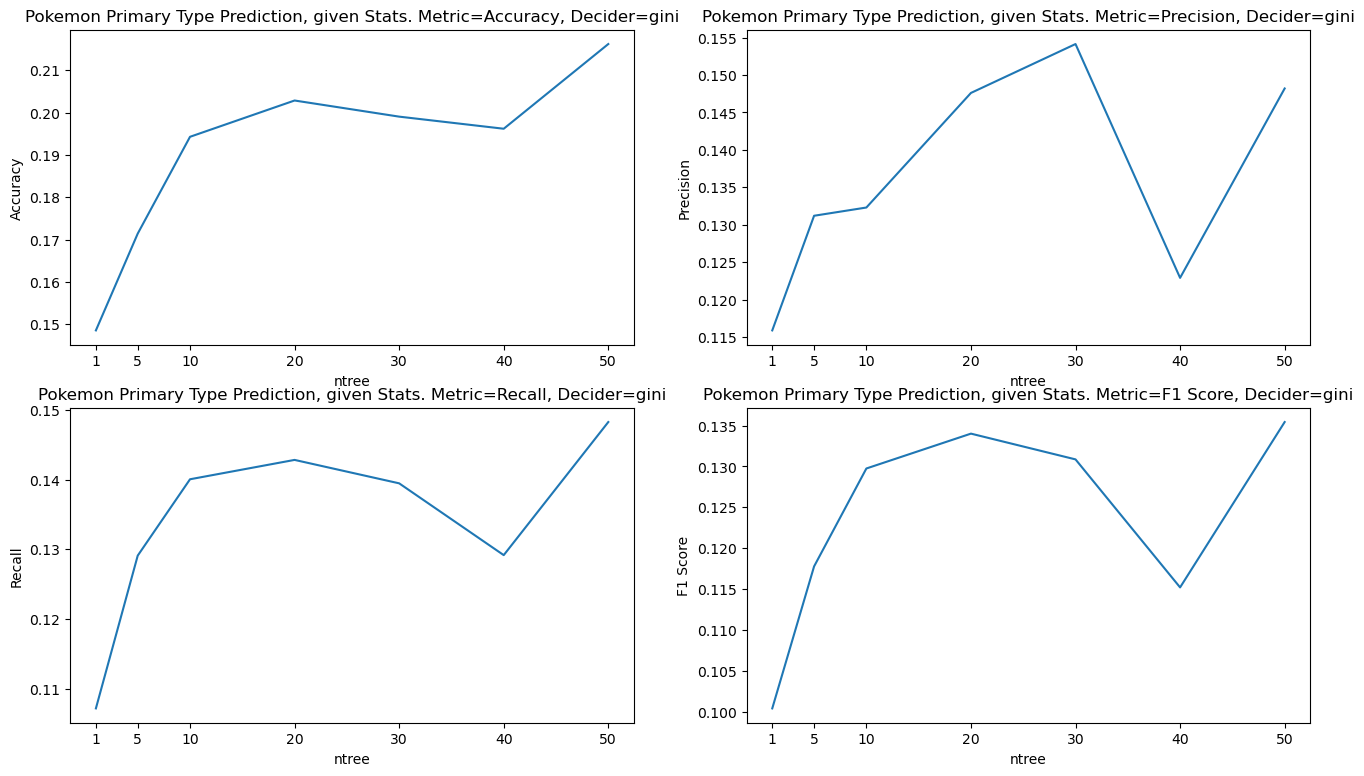

In [35]:
plt.figure(figsize=(16, 9))  # Adjust the figure size if needed
plt.subplot(2,2,1)
plt.plot(ntree_vals,[entry['accuracy'] for entry in poke_ntree_performances_gini.values()])
plt.xlabel("ntree")
plt.ylabel("Accuracy")
plt.xticks(ntree_vals)
plt.title("Pokemon Primary Type Prediction, given Stats. Metric=Accuracy, Decider=gini")
plt.subplot(2,2,2)
plt.plot(ntree_vals,[entry['precision'] for entry in poke_ntree_performances_gini.values()])
plt.xlabel("ntree")
plt.ylabel("Precision")
plt.xticks(ntree_vals)
plt.title("Pokemon Primary Type Prediction, given Stats. Metric=Precision, Decider=gini")
plt.subplot(2,2,3)
plt.plot(ntree_vals,[entry['recall'] for entry in poke_ntree_performances_gini.values()])
plt.xlabel("ntree")
plt.ylabel("Recall")
plt.xticks(ntree_vals)
plt.title("Pokemon Primary Type Prediction, given Stats. Metric=Recall, Decider=gini")
plt.subplot(2,2,4)
plt.plot(ntree_vals,[entry['F1'] for entry in poke_ntree_performances_gini.values()])
plt.xlabel("ntree")
plt.ylabel("F1 Score")
plt.xticks(ntree_vals)
plt.title("Pokemon Primary Type Prediction, given Stats. Metric=F1 Score, Decider=gini")

Text(0.5, 1.0, 'Pokemon Primary Type Prediction, given Stats. Metric=F1 Score, Decider=i_gain')

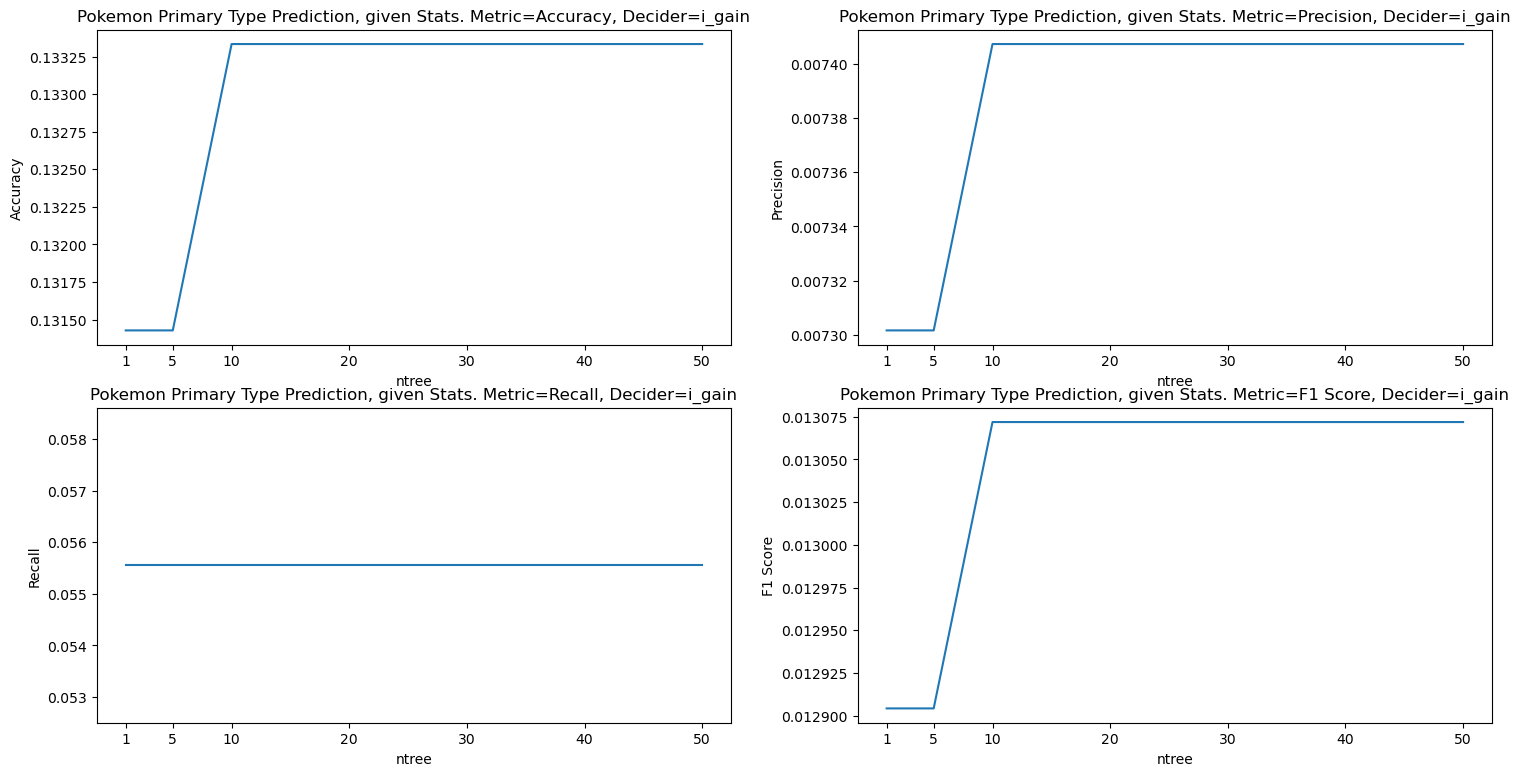

In [36]:
plt.figure(figsize=(18, 9))  # Adjust the figure size if needed
plt.subplot(2,2,1)
plt.plot(ntree_vals,[entry['accuracy'] for entry in poke_ntree_performances_i_gain.values()])
plt.xlabel("ntree")
plt.ylabel("Accuracy")
plt.xticks(ntree_vals)
plt.title("Pokemon Primary Type Prediction, given Stats. Metric=Accuracy, Decider=i_gain")
plt.subplot(2,2,2)
plt.plot(ntree_vals,[entry['precision'] for entry in poke_ntree_performances_i_gain.values()])
plt.xlabel("ntree")
plt.ylabel("Precision")
plt.xticks(ntree_vals)
plt.title("Pokemon Primary Type Prediction, given Stats. Metric=Precision, Decider=i_gain")
plt.subplot(2,2,3)
plt.plot(ntree_vals,[entry['recall'] for entry in poke_ntree_performances_i_gain.values()])
plt.xlabel("ntree")
plt.ylabel("Recall")
plt.xticks(ntree_vals)
plt.title("Pokemon Primary Type Prediction, given Stats. Metric=Recall, Decider=i_gain")
plt.subplot(2,2,4)
plt.plot(ntree_vals,[entry['F1'] for entry in poke_ntree_performances_i_gain.values()])
plt.xlabel("ntree")
plt.ylabel("F1 Score")
plt.xticks(ntree_vals)
plt.title("Pokemon Primary Type Prediction, given Stats. Metric=F1 Score, Decider=i_gain")